# Building a Play Classifier Using Transfer Learning
Trying to identify clips of challenges from Bundesliga games. This transfer learning model will be built with fastai and this notebook will build and train that model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_path = Path('data/')
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [3]:
df_play = train_df[train_df['event'] == 'play'].copy()
print(len(df_play))
df_play.head()

3586


,video_id,time,event,event_attributes
10,1606b0e6_0,224.43,play,"['pass', 'openplay']"
13,1606b0e6_0,229.39,play,"['pass', 'openplay']"
16,1606b0e6_0,236.71,play,"['pass', 'openplay']"
17,1606b0e6_0,239.35,play,"['pass', 'openplay']"
20,1606b0e6_0,242.39,play,"['pass', 'openplay']"


In [4]:
df_play.groupby(['event_attributes']).nunique()

,video_id,time,event
event_attributes,,,
"['cross', 'corner']",12,33,1
"['cross', 'freekick']",4,5,1
"['cross', 'openplay']",12,80,1
"['pass', 'corner']",3,4,1
"['pass', 'freekick']",12,127,1
"['pass', 'openplay']",12,3330,1


In [5]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename
    )
    
    return Video(filename, width=800)

In [6]:
r = df_play.iloc[5]
vis_event(r,1,1)

['pass', 'openplay']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [7]:
fps = 25
def get_images(vid_id, time, ind, time_diff, replace=False):
    t1 = time - time_diff
    t2 = time + time_diff
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)

    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/f'{ind}'
    if not os.path.exists(p):
        os.makedirs(p)
    for j in range(frame_start, frame_end + 1):
        if not os.path.exists(p/f'{j}.png') or replace == True:
            try:
                image = iio.imread(f'{video_file}.mp4', index=j)
                iio.imwrite(p/f'{j}.png', image)
            except IndexError:
                print(j, p)
                p = None
    return p

In [22]:
# creating positive set
scale = 3
df_pos = df_play[df_play.event_attributes.str.contains('cross') | df_play.event_attributes.str.contains('corner') | df_play.event_attributes.str.contains('freekick')]
print(df_pos.shape)
df_pos = pd.concat([df_pos, df_play[df_play['event_attributes'] == "['pass', 'openplay']"].sample(n=len(df_pos)*scale,replace=False, random_state=42)], axis=0)
df_pos

(249, 4)


,video_id,time,event,event_attributes
43,1606b0e6_0,272.110,play,"['cross', 'openplay']"
66,1606b0e6_0,313.230,play,"['cross', 'openplay']"
73,1606b0e6_0,356.230,play,"['pass', 'freekick']"
76,1606b0e6_0,361.390,play,"['cross', 'openplay']"
153,1606b0e6_0,556.710,play,"['cross', 'openplay']"
...,...,...,...,...
3513,35bd9041_1,1157.157,play,"['pass', 'openplay']"
2193,1606b0e6_1,3272.790,play,"['pass', 'openplay']"
11154,ecf251d4_0,2946.827,play,"['pass', 'openplay']"
2207,1606b0e6_1,3297.950,play,"['pass', 'openplay']"


In [23]:
fnames = [get_images(v, t, i, 0.15) for v, t, i in tqdm(zip(df_pos['video_id'], df_pos['time'], df_pos.index.values), total=len(df_pos))]
df_pos['fnames'] = fnames
print(len(fnames))
fnames[0:3]

  0%|          | 0/996 [00:00<?, ?it/s]

996


[Path('data/1606b0e6_0/43'),
 Path('data/1606b0e6_0/66'),
 Path('data/1606b0e6_0/73')]

In [24]:
fnames = []
for a in data_path.ls():
    if '.' not in str(a) and 'test' not in str(a):
        for b in a.ls():
            if '-' not in str(b):
                fnames.append(b)
len(fnames)
fnames=fnames[:996]
df_pos['fnames'] = fnames
print(len(fnames))
fnames[0:3]

996


[Path('data/1606b0e6_0/1'),
 Path('data/1606b0e6_0/10'),
 Path('data/1606b0e6_0/101')]

In [25]:
# making a negative dataset the size of the positive one
scale = 1

pos_set = df_play['time'].astype(int)
neg_set = [x for x in range(1,12*60) if x not in pos_set]


neg_paths = []
for a in data_path.ls():
    if '.' not in str(a):
        for b in a.ls():
            if '-' in str(b):
                neg_paths.append(b)

while len(neg_paths) < scale * len(df_pos):
    count = len(neg_paths)
    vid_paths = data_path/'train'
    vid_paths = vid_paths.ls()
    index = -1*len(neg_paths)
    for t in tqdm(neg_set):
        i = random.randint(0,len(vid_paths)-1)
        p = data_path/vid_paths[i].stem/str(index)
        while p in fnames or p in neg_paths: # the first "p in fnames" isn't doing what it is supposed to but i think it is ok
            i = random.randint(0,len(vid_paths)-1)
            p = data_path/vid_paths[i].stem/str(index)
        neg_paths.append(get_images(vid_paths[i].stem, t, index, 0.15))
        index += -1
        count += 1
        if count == scale * len(df_pos):
            break

    print(len(neg_paths))


In [26]:
print(len(neg_paths))
neg_paths[:3]

996


[Path('data/1606b0e6_0/-102'),
 Path('data/1606b0e6_0/-112'),
 Path('data/1606b0e6_0/-137')]

In [27]:
df_train = pd.DataFrame(df_pos.fnames.copy())
df_train['label'] = ['play'] * len(df_pos)
len(df_train)
df_neg = pd.DataFrame({'fnames': neg_paths, 'label': ['no_play'] * len(neg_paths)})
df_train = pd.concat([df_train, df_neg])

In [28]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [29]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [30]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [31]:
def labeller(path):
    if path in neg_paths:
        return 'no_play'
    else:
        return 'play'

In [32]:
instances_path = df_train.fnames.copy()
splits = RandomSplitter()(instances_path)

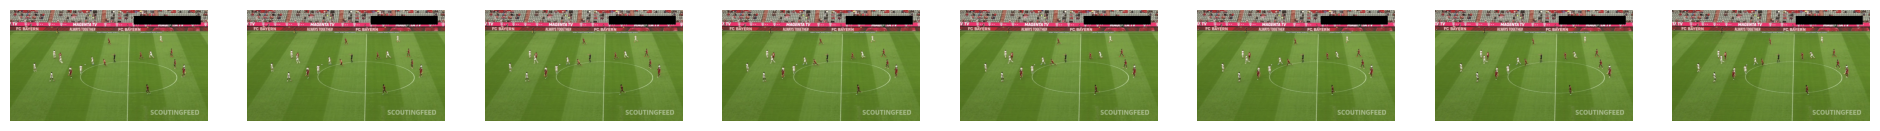

In [33]:
frames = instances_path[0].ls_sorted()
show_images([Image.open(img) for img in frames])

In [34]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [labeller, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


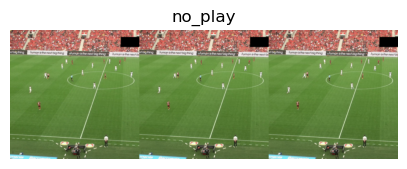

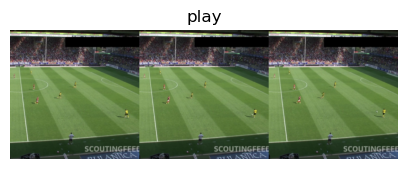

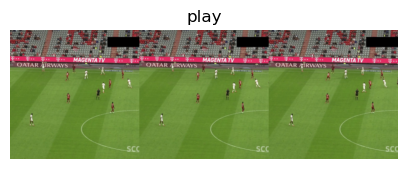

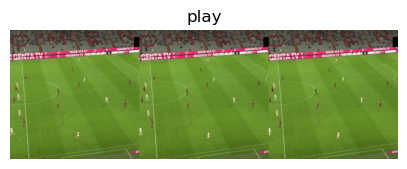

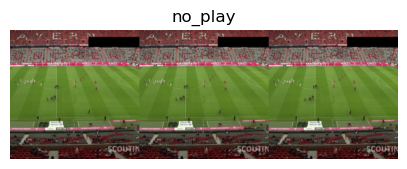

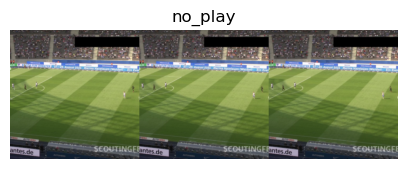

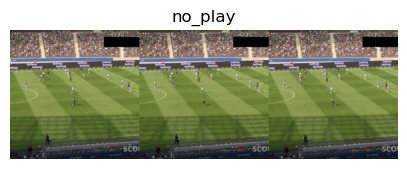

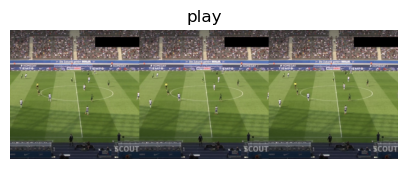

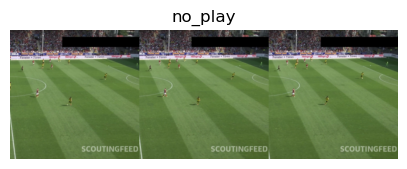

In [35]:
dls = get_action_dataloaders(instances_path, bs=16, image_size=256, seq_len=8)
dls.show_batch()

In [36]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [37]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [38]:
model = RNNModel().cuda()

In [39]:
learn = Learner(dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(valley=0.0014454397605732083)

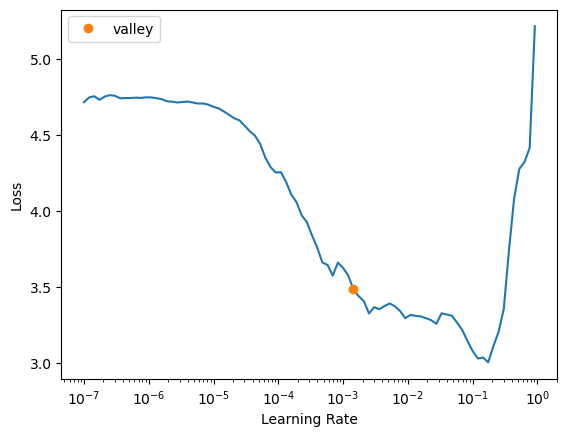

In [40]:
learn.lr_find()

In [41]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,2.667162,5.400022,0.565327,0.434673,21:57


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.630610,1.098082,0.135678,0.864322,20:13
1,1.225762,0.409085,0.118090,0.881910,20:13
2,0.847837,0.501717,0.140704,0.859296,20:08
3,0.542476,0.464084,0.118090,0.881910,20:10
4,0.471327,0.380911,0.110553,0.889447,19:59


In [42]:
learn.save('play_256_v2')
learn.export('play_256_v2.pkl')

In [43]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.426120,0.972810,0.412060,0.587940,18:51


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.360409,1.083310,0.354271,0.645729,18:49
1,0.337934,0.279950,0.120603,0.879397,18:54
2,0.316923,0.305580,0.123116,0.876884,18:44
3,0.314481,0.247735,0.115578,0.884422,18:45
4,0.290735,0.245782,0.113065,0.886935,18:54


In [44]:
learn.save('play_256_v3')
learn.export('play_256_v3.pkl')

Best params so far:
- 8 frames
- Image size: 256
- Epochs trained: 8
- Batch Size: 16
- Error Rate/F1: 6.5%/0.93
- filename: challenge_256_92.pth

Try Next:
- identify frames of playtime vs not playtime

In [35]:
learn.load('play_256')
learn.export('play_256.pkl')